# Final Presentation Notebook

In [11]:
import pandas as pd
import seaborn as sns
from yellowbrick.classifier import ClassificationReport, ConfusionMatrix

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from yellowbrick.text import FreqDistVisualizer

from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve

import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

### Load in filtered dataset and look at the formatting
The columns of interest at ['filter_title', 'filter_title_no_stops', 'category_id']
    1. 'filter_title' --> raw input that only has punctuation removed and letters to lower case
    2. 'filter_title_no_stops' --> 'filter_title' data with addition to removal of stopwords
    3. 'category_id' --> output/buckets to categorize video (16 total)

In [2]:
df_titles_info = pd.read_csv('./output/US_count_vectorizer_dataset.csv')
df_titles_info.head()

,title,filter_title,filter_title_no_stops,category_id
0,WE WANT TO TALK ABOUT OUR MARRIAGE,we want to talk about our marriage,want talk marriage,People & Blogs
1,The Trump Presidency: Last Week Tonight with J...,the trump presidency last week tonight with jo...,trump presidency last week tonight john oliver...,Entertainment
2,"Racist Superman | Rudy Mancuso, King Bach & Le...",racist superman rudy mancuso king bach lele pons,racist superman rudy mancuso king bach lele pons,Comedy
3,Nickelback Lyrics: Real or Fake?,nickelback lyrics real or fake,nickelback lyrics real fake,Entertainment
4,I Dare You: GOING BALD!?,i dare you going bald,dare going bald,Entertainment


### Split dataset before vectorizing
This guards against leaking information from testing to training set (80% training, 20% testing)

https://machinelearningmastery.com/data-leakage-machine-learning/
https://stackoverflow.com/questions/54491953/can-i-use-countvectorizer-on-both-test-and-train-data-at-the-same-time-or-do-i-n

In [3]:
df_x = df_titles_info['filter_title']
df_y = df_titles_info['category_id']
df_x_stop = df_titles_info['filter_title_no_stops']

target_names = list(df_titles_info['category_id'].unique())

x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=117)
x_train_stop, x_test_stop = train_test_split(df_x_stop, test_size=0.2, random_state=117)

x_train_stop = x_train_stop.fillna(' ')
x_test_stop = x_test_stop.fillna(' ')
print("Training data size:", x_train.shape)
print("Testing data size:", x_test.shape)
print("Training data size:", x_train_stop.shape)
print("Testing data size:", x_test_stop.shape)

Training data size: (32759,)
Testing data size: (8190,)
Training data size: (32759,)
Testing data size: (8190,)


### Tokenizer words using CountVectorizer
Bag-of-Words model that allows both tokenize a collection of text documents and build a vocabulary of known words

The length of each individual vector will be that of the entire dataset which each indices representing the count of a specific word

In [4]:
count_vectorizer = CountVectorizer()
train_count_vector = count_vectorizer.fit_transform(x_train)
test_count_vector = count_vectorizer.transform(x_test)

train_count_vector_stop = count_vectorizer.fit_transform(x_train_stop)
test_count_vector_stop = count_vectorizer.transform(x_test_stop)

### Tokenizer words using TfidfTransformer
Will convert our count values from CountVectorizer into a frequency matrix

Term Frequency: How often a word appears in a particular title.
Inverse Document Frequency: Downscale this words that appear often across multiple titles.

Main purpose is to reduce the importance of stopwords that a common accross categories

In [5]:
tfidf_vectorizer = TfidfTransformer()
x_trained_tfidf_vector = tfidf_vectorizer.fit_transform(train_count_vector)
x_test_tfidf_vector = tfidf_vectorizer.transform(test_count_vector)

## Model Training and Prediction

### Naive Bayes Model Training

### Create, Train, and Predict a Multinomial Naive Bayes Model using CountVectors

Accuracy:  0.8996336996336997
Precision:  0.9007077699892384
F1:  0.8989440396735326
                       precision    recall  f1-score   support

     Autos & Vehicles       0.93      0.75      0.83        91
               Comedy       0.91      0.82      0.86       664
            Education       0.91      0.95      0.93       329
        Entertainment       0.89      0.89      0.89      2016
     Film & Animation       0.93      0.88      0.90       495
               Gaming       0.96      0.89      0.92       149
        Howto & Style       0.85      0.92      0.89       823
                Music       0.92      0.96      0.94      1245
      News & Politics       0.92      0.93      0.92       523
Nonprofits & Activism       1.00      0.20      0.33        10
       People & Blogs       0.91      0.83      0.87       660
       Pets & Animals       0.94      0.89      0.91       186
 Science & Technology       0.87      0.92      0.89       461
                Shows       1.00

C:\Users\lukev\Anaconda3\envs\yt-trends\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


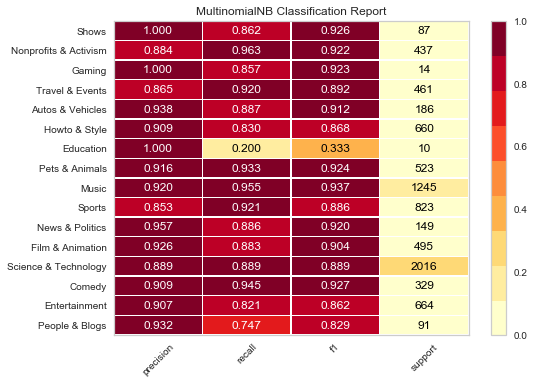

In [6]:
clf_count = MultinomialNB()
clf_count.fit(train_count_vector, y_train)

pred_count = clf_count.predict(test_count_vector)
print("Accuracy: ", metrics.accuracy_score(y_test, pred_count))
print("Precision: ", metrics.precision_score(y_test, pred_count, average='weighted'))
print("F1: ", metrics.f1_score(y_test, pred_count, average='weighted'))
print(metrics.classification_report(y_test, pred_count))

visualizer = ClassificationReport(clf_count, classes=target_names, support=True)
visualizer.fit(train_count_vector, y_train)
visualizer.score(test_count_vector, y_test)
visualizer.show()

C:\Users\lukev\Anaconda3\envs\yt-trends\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


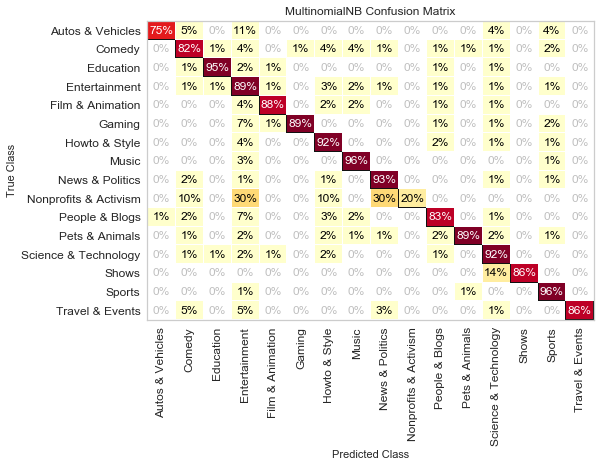

In [7]:
# conf_matrix = metrics.confusion_matrix(y_test, pred_count, labels=target_names)
# conf_df = pd.DataFrame(conf_matrix, index=target_names, columns=target_names)

# plt.figure(figsize=(15,6))
# sns.heatmap(conf_df, cmap='YlOrRd', annot=True, fmt='d')
# plt.title('Count NB Model\nAccuracy:{0:.3f}'.format(metrics.accuracy_score(y_test, pred_count)))
# plt.ylabel('True label')
# plt.xlabel('Predicted label')
# plt.show()

conf_matrix = ConfusionMatrix(clf_count, cmapstring='YlOrRd', percent=True)
conf_matrix.fit(train_count_vector, y_train)
conf_matrix.score(test_count_vector, y_test)
conf_matrix.show()

### Create, Train, and Predict a Multinomial Naive Bayes Model using Tfidf Vector

Accuracy:  0.860927960927961
Precision:  0.8821316148369487
F1:  0.8575833321942375


C:\Users\lukev\Anaconda3\envs\yt-trends\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lukev\Anaconda3\envs\yt-trends\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                       precision    recall  f1-score   support

     Autos & Vehicles       1.00      0.20      0.33        91
               Comedy       0.92      0.77      0.84       664
            Education       0.98      0.79      0.88       329
        Entertainment       0.72      0.97      0.82      2016
     Film & Animation       0.99      0.75      0.86       495
               Gaming       1.00      0.59      0.74       149
        Howto & Style       0.89      0.91      0.90       823
                Music       0.91      0.96      0.93      1245
      News & Politics       0.96      0.85      0.90       523
Nonprofits & Activism       0.00      0.00      0.00        10
       People & Blogs       0.96      0.72      0.82       660
       Pets & Animals       0.99      0.77      0.87       186
 Science & Technology       0.91      0.84      0.87       461
                Shows       1.00      0.57      0.73        14
               Sports       0.94      0.94      0.94  

C:\Users\lukev\Anaconda3\envs\yt-trends\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
C:\Users\lukev\Anaconda3\envs\yt-trends\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


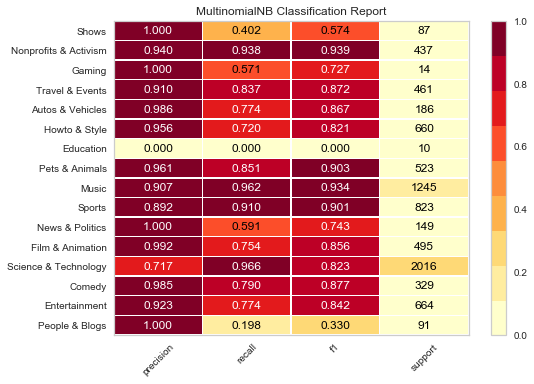

In [8]:
clf_tfidf = MultinomialNB()
clf_tfidf.fit(x_trained_tfidf_vector, y_train)

pred_tfidf = clf_tfidf.predict(x_test_tfidf_vector)
print("Accuracy: ", metrics.accuracy_score(y_test, pred_tfidf))
print("Precision: ", metrics.precision_score(y_test, pred_tfidf, average='weighted'))
print("F1: ", metrics.f1_score(y_test, pred_tfidf, average='weighted'))
print(metrics.classification_report(y_test, pred_tfidf))

visualizer = ClassificationReport(clf_tfidf, classes=target_names, support=True)
visualizer.fit(x_trained_tfidf_vector, y_train)
visualizer.score(x_test_tfidf_vector, y_test)
visualizer.show()

C:\Users\lukev\Anaconda3\envs\yt-trends\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


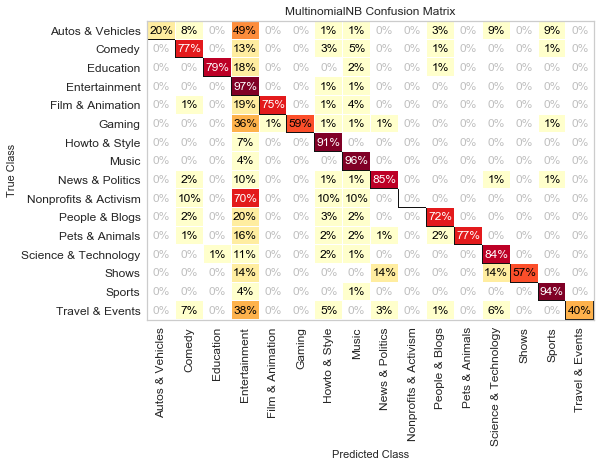

In [9]:
# conf_matrix = metrics.confusion_matrix(y_test, pred_tfidf, labels=target_names)
# conf_df = pd.DataFrame(conf_matrix, index=target_names, columns=target_names)

# plt.figure(figsize=(15,6))
# sns.heatmap(conf_df, cmap='YlOrRd', annot=True, fmt='d')
# plt.title('Tfidf NB Model\nAccuracy:{0:.3f}'.format(metrics.accuracy_score(y_test, pred_tfidf)))
# plt.ylabel('True label')
# plt.xlabel('Predicted label')
# plt.show()

conf_matrix = ConfusionMatrix(clf_tfidf, cmapstring='YlOrRd', percent=True)
conf_matrix.fit(x_trained_tfidf_vector, y_train)
conf_matrix.score(x_test_tfidf_vector, y_test)
conf_matrix.show()

### Utilize SMOTE to oversample minority classes
Oversampling to have the same number of features in minority classes as in majority classes

In [12]:
smote = SMOTE(sampling_strategy='not majority')

x_train_smote, y_train_smote = smote.fit_sample(train_count_vector, y_train)

print(y_train.value_counts().tail())
print()
print(y_train_smote.value_counts().tail())

Gaming                   668
Travel & Events          315
Autos & Vehicles         293
Nonprofits & Activism     47
Shows                     43
Name: category_id, dtype: int64

Autos & Vehicles    7948
Pets & Animals      7948
Education           7948
Sports              7948
Travel & Events     7948
Name: category_id, dtype: int64


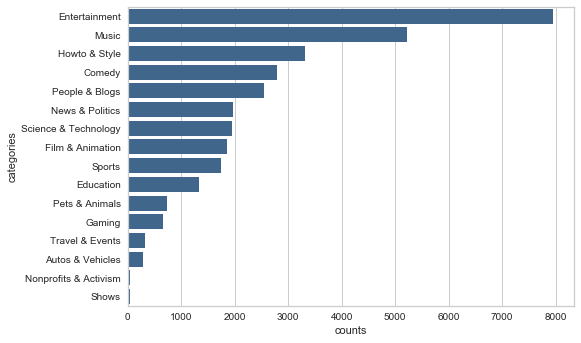

In [13]:
norm_smp = y_train.value_counts().rename_axis('categories').reset_index(name='counts')
plot_norm = sns.barplot(x='counts', y='categories',data=norm_smp, color=(0.2, 0.4, 0.6, 0.6))

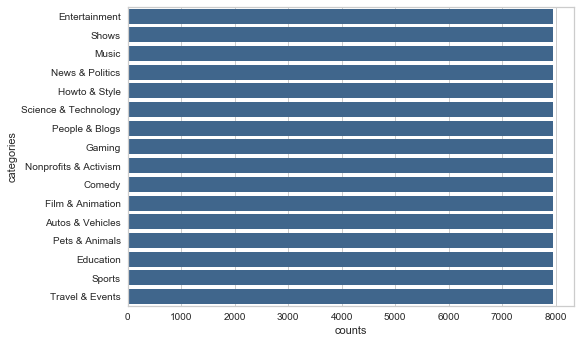

In [14]:
over_smp = y_train_smote.value_counts().rename_axis('categories').reset_index(name='counts')
plot_over = sns.barplot(x='counts', y='categories',data=over_smp, color=(0.2, 0.4, 0.6, 0.6))

Count Model
Accuracy:  0.8957264957264958
Precision:  0.8995902078132371
F1:  0.8949657226901174
                       precision    recall  f1-score   support

     Autos & Vehicles       0.77      0.95      0.85        91
               Comedy       0.90      0.85      0.87       664
            Education       0.87      0.97      0.91       329
        Entertainment       0.95      0.79      0.86      2016
     Film & Animation       0.84      0.92      0.88       495
               Gaming       0.81      0.97      0.89       149
        Howto & Style       0.87      0.93      0.90       823
                Music       0.94      0.95      0.94      1245
      News & Politics       0.90      0.93      0.92       523
Nonprofits & Activism       0.77      1.00      0.87        10
       People & Blogs       0.85      0.89      0.87       660
       Pets & Animals       0.87      0.97      0.92       186
 Science & Technology       0.85      0.95      0.90       461
                Show

C:\Users\lukev\Anaconda3\envs\yt-trends\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


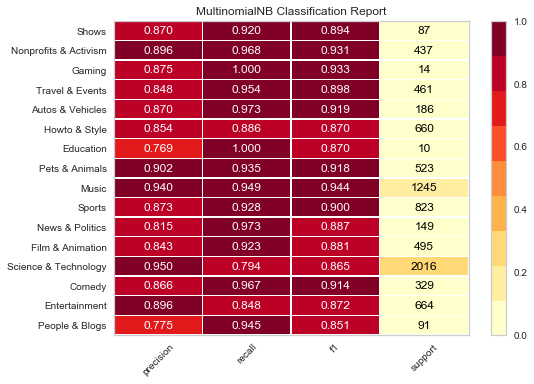

In [15]:
clf_count.fit(x_train_smote, y_train_smote)

pred_count_smote = clf_count.predict(test_count_vector)
print("Count Model")
print("Accuracy: ", metrics.accuracy_score(y_test, pred_count_smote))
print("Precision: ", metrics.precision_score(y_test, pred_count_smote, average='weighted'))
print("F1: ", metrics.f1_score(y_test, pred_count_smote, average='weighted'))
print(metrics.classification_report(y_test, pred_count_smote))

visualizer = ClassificationReport(clf_count, classes=target_names, support=True, cmap='YlOrRd')
visualizer.fit(x_train_smote, y_train_smote)
visualizer.score(test_count_vector, y_test)
visualizer.show()

C:\Users\lukev\Anaconda3\envs\yt-trends\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


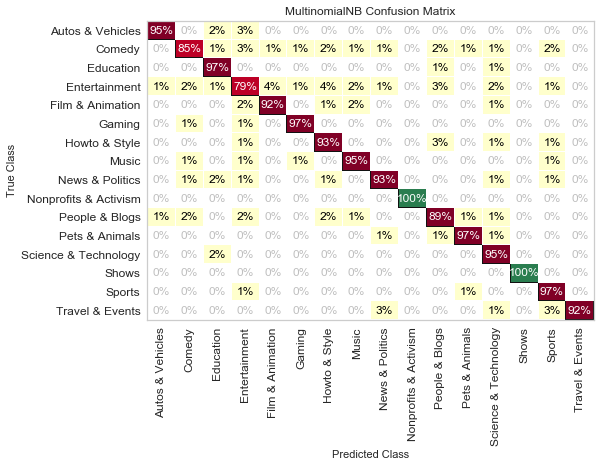

In [16]:
# conf_matrix = metrics.confusion_matrix(y_test, pred_count_smote, labels=target_names)
# conf_df = pd.DataFrame(conf_matrix, index=target_names, columns=target_names)

# plt.figure(figsize=(15,6))
# sns.heatmap(conf_df, cmap='YlOrRd', annot=True, fmt='d')
# plt.title('SMOTE NB Model \nAccuracy:{0:.3f}'.format(metrics.accuracy_score(y_test, pred_count_smote)))
# plt.ylabel('True label')
# plt.xlabel('Predicted label')
# plt.show()

conf_matrix = ConfusionMatrix(clf_count, cmapstring='YlOrRd', percent=True)
conf_matrix.fit(x_train_smote, y_train_smote)
conf_matrix.score(test_count_vector, y_test)
conf_matrix.show()

### Analysis
Overall the model seems to perform pretty well. Accuracy of all three variance of NB are in accurate range. One outlier seems to be Nonprodits & Activism category as the accuracy seems to be consistently lower then other categories. This may be due to the little training data in the initial dataset. However, once we oversample the minority classes, we see that recalls goes to 100%. 

In [17]:
clf_count = MultinomialNB()
clf_count.fit(train_count_vector, y_train)
pred_count = clf_count.predict(test_count_vector)
clf_acc_count = accuracy_score(y_test, pred_count)

clf_count_stop = MultinomialNB()
clf_count_stop.fit(train_count_vector_stop, y_train)
pred_count_stop = clf_count_stop.predict(test_count_vector_stop)
clf_acc_count_stop = accuracy_score(y_test, pred_count_stop)

clf_tfidf = MultinomialNB()
clf_tfidf.fit(x_trained_tfidf_vector, y_train)
pred_tfidf = clf_tfidf.predict(x_test_tfidf_vector)
clf_acc_tfidf = accuracy_score(y_test, pred_tfidf)

In [18]:
forest_count=RandomForestClassifier(n_estimators=100)
forest_count.fit(train_count_vector,y_train)
pred_count = forest_count.predict(test_count_vector)
forest_acc_count = accuracy_score(y_test, pred_count)

forest_count_stop=RandomForestClassifier(n_estimators=100)
forest_count_stop.fit(train_count_vector_stop,y_train)
pred_count_stop = forest_count_stop.predict(test_count_vector_stop)
forest_acc_count_stop =  accuracy_score(y_test, pred_count_stop)

forest_tfidf=RandomForestClassifier(n_estimators=100)
forest_tfidf.fit(x_trained_tfidf_vector,y_train)
pred_tfidf = forest_tfidf.predict(x_test_tfidf_vector)
forest_acc_tfidf = accuracy_score(y_test, pred_tfidf)

In [19]:
log_count = LogisticRegression(solver='lbfgs', max_iter = 4000)
log_count.fit(train_count_vector, y_train)
pred_count = log_count.predict(test_count_vector)
log_acc_count = accuracy_score(y_test, pred_count)

log_count_stop = LogisticRegression(solver='lbfgs', max_iter = 4000)
log_count_stop.fit(train_count_vector_stop, y_train)
pred_count_stop = log_count_stop.predict(test_count_vector_stop)
log_acc_count_stop =  accuracy_score(y_test, pred_count_stop)

log_tfidf = LogisticRegression(solver='lbfgs', max_iter = 4000)
log_tfidf.fit(x_trained_tfidf_vector, y_train)
pred_tfidf = log_tfidf.predict(x_test_tfidf_vector)
log_acc_tfidf = accuracy_score(y_test, pred_tfidf)

In [20]:
svm_count = SVC(kernel='linear')
svm_count.fit(train_count_vector, y_train)
pred_count = svm_count.predict(test_count_vector)
svm_acc_count = accuracy_score(y_test, pred_count)

svm_count_stop = SVC(kernel='linear')
svm_count_stop.fit(train_count_vector_stop, y_train)
pred_count_stop = svm_count_stop.predict(test_count_vector_stop)
svm_acc_count_stop = accuracy_score(y_test, pred_count_stop)

svm_tfidf = SVC(kernel='linear')
svm_tfidf.fit(x_trained_tfidf_vector, y_train)
pred_tfidf = svm_tfidf.predict(x_test_tfidf_vector)
svm_acc_tfidf = accuracy_score(y_test, pred_tfidf)

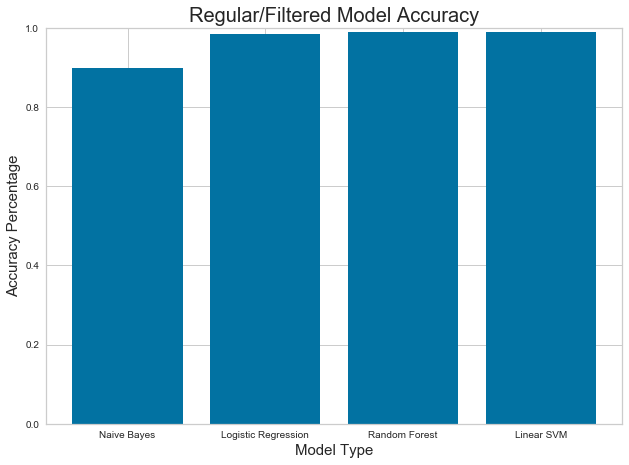

In [21]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
plt.ylim(0, 1)
x = ["Naive Bayes", "Logistic Regression", "Random Forest", "Linear SVM"]
y = [clf_acc_count, log_acc_count, forest_acc_count, svm_acc_count]

plt.title('Regular/Filtered Model Accuracy', fontsize=20)
plt.xlabel('Model Type', fontsize=15)
plt.ylabel('Accuracy Percentage', fontsize=15)
ax.bar(x,y)
plt.show()

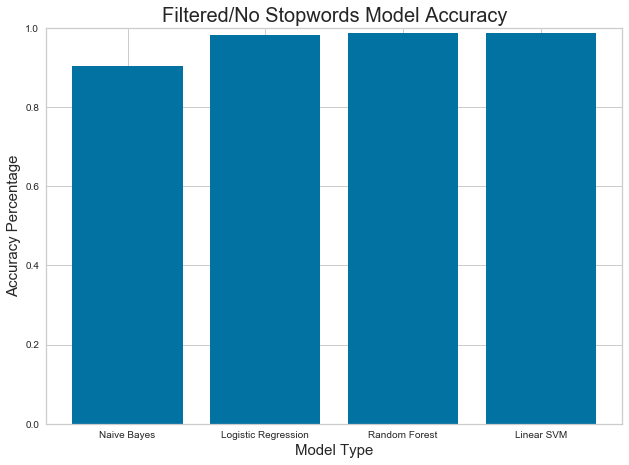

In [22]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
plt.ylim(0, 1)
x = ["Naive Bayes", "Logistic Regression", "Random Forest", "Linear SVM"]
y = [clf_acc_count_stop, log_acc_count_stop, forest_acc_count_stop, svm_acc_count_stop]

plt.title('Filtered/No Stopwords Model Accuracy', fontsize=20)
plt.xlabel('Model Type', fontsize=15)
plt.ylabel('Accuracy Percentage', fontsize=15)
ax.bar(x,y)
plt.show()

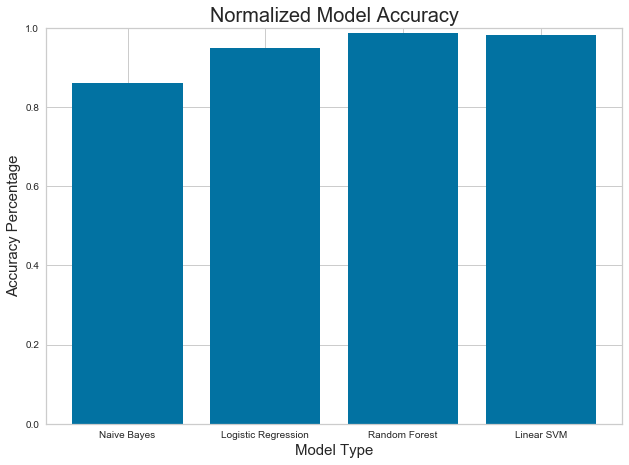

In [23]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
plt.ylim(0, 1)
x = ["Naive Bayes", "Logistic Regression", "Random Forest", "Linear SVM"]
y = [clf_acc_tfidf, log_acc_tfidf, forest_acc_tfidf, svm_acc_tfidf]

plt.title('Normalized Model Accuracy', fontsize=20)
plt.xlabel('Model Type', fontsize=15)
plt.ylabel('Accuracy Percentage', fontsize=15)
ax.bar(x,y)
plt.show()